In [1]:
import os
import numpy as np 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
### read data from files
features = torch.from_numpy(np.load('./train_zs.npy'))
labels = torch.from_numpy(np.load('./train_label.npy'))
num_classes = len(np.unique(labels))
num_samples = len(features)

ori_features = features.clone().detach()
mu_f = [features[labels==c].mean(0) for c in range(num_classes)]
std_f = [features[labels==c].std(0) for c in range(num_classes)]

features.shape, labels.shape  

(torch.Size([1498, 768]), torch.Size([1498]))

In [5]:
k_top = 200 ### hyperparam
topk_ind = torch.stack([mu.topk(k=k_top).indices for mu in mu_f], dim=0)
topk_val = torch.stack([mu.topk(k=k_top).values for mu in mu_f], dim=0)

##### synthesize feature with class-wise topk val replacement

In [6]:
from tqdm import tqdm
import random

method = ['instance', 'category'][0] ### hparam: instance mixing or category-mean mixing
swap_method = ['a', 'b'][0] ### hparam: swap A or B, NOTE: to avoid `instance` + `b`
mixed_features = torch.zeros([ori_features.size(0), num_classes, ori_features.size(1)]) ### output mixing feature: samples (class A) x classes B x dimensions

for i in tqdm(range(ori_features.size(0))):
    line = ori_features[i].clone()
    class_a = labels[i]
    for class_b in range(num_classes):
        if method == 'instance':
            class_mask = torch.where(labels == class_b)
            sample_b = random.choice(class_mask[0]).item()
            feat_b = ori_features[sample_b]
        elif method == 'category':
            feat_b = mu_f[class_b]
        else:
            raise NotImplementedError()
        replace_ind = topk_ind[class_a if swap_method == 'a' else class_b]
        line[replace_ind] = feat_b[replace_ind]
        mixed_features[i, class_b] = line

100%|██████████| 4496/4496 [01:00<00:00, 73.93it/s]


##### compute topk_ind to class_ind (deprecated)

In [7]:
from collections import defaultdict
index_to_classes = defaultdict(list)
for cls in range(num_classes):
    for ind in topk_ind[cls]:
        index_to_classes[ind.item()].append(cls)
        
index_to_classes = dict(index_to_classes)

In [8]:
index_to_classlen = {ind: len(cls_list) for ind, cls_list in index_to_classes.items()}

##### TSNE visualization

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np


def visualize_reduction(features, labels=None, method='tsne', n_components=2, **kwargs):
    """
    Reduce dimensionality using t-SNE, PCA, or UMAP and visualize.
    
    Parameters:
    - features (ndarray): Input features of shape (num_samples, feature_dim).
    - labels (ndarray or None): Labels for coloring points (optional).
    - method (str): Dimensionality reduction method ('tsne', 'pca', 'umap').
    - n_components (int): Number of reduced dimensions (default: 2).
    - kwargs: Additional arguments for the reduction method.
    
    Returns:
    - reduced_features (ndarray): Reduced feature array of shape (num_samples, n_components).
    """
    if isinstance(features, list):
        split_indices = [len(f) for f in features]
        features = torch.cat(features, dim=0)
    else:
        split_indices = None
    features_normalized = (features - features.mean(0)) / features.std(0)

    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1500, **kwargs)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42, n_neighbors=15, min_dist=0.1, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'tsne', 'pca', 'umap'.")
    
    reduced_features = reducer.fit_transform(features_normalized)
    if split_indices:
        reduced_features_list = np.split(reduced_features, np.cumsum(split_indices)[:-1])

    plt.figure(figsize=(10, 8), dpi=128)
    if split_indices:
        markers = ['o', '^']
        for idx, reduced_features in enumerate(reduced_features_list):
            marker = markers[idx % len(markers)]  # Cycle markers if more than 2
            scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                                  c=labels, 
                                  cmap='tab10', 
                                  s=8, 
                                  alpha=0.7, 
                                  marker=marker, 
                                  edgecolor='black',
                                  linewidth=0.2,
                                  label=f"Features {idx + 1}")
    else:
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                               c=labels, cmap='tab10', s=5, alpha=0.7)
    if labels is not None:
        plt.colorbar(scatter, label='Labels')
    plt.title(f"{method.upper()} Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()
    return reduced_features


/home/xinyu.li/miniconda3/envs/hx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
### visualization ablations
# random_classes = np.random.choice(np.unique(labels), size=20, replace=False)
# mask = np.isin(labels, random_classes)
# filtered_features = ori_features[mask]
# filtered_labels = labels[mask]

# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='tsne')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='pca')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='umap')


In [10]:
### subset classes for visualization
random_classes = np.random.choice(np.unique(labels), size=50, replace=False)
mask = np.isin(labels, random_classes)
filtered_features = mixed_features[mask]
filtered_labels = labels[mask]
filtered_conf_ind_top = conf_ind_top[filtered_labels]
filtered_conf_ind_low = conf_ind_low[filtered_labels]


features_2d = visualize_reduction([filtered_features[:, 0], filtered_features[:, 85]], labels=filtered_labels, method='tsne')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='pca')
# features_2d = visualize_reduction(filtered_features, labels=filtered_labels, method='umap')


NameError: name 'conf_ind_top' is not defined

In [11]:
### design 1: high topk overlapping
features_2d = visualize_reduction([
    filtered_features[:, 0], 
    filtered_features[
    torch.arange(filtered_features.size(0)), 
    filtered_conf_ind_top[:, 0]]
], 
    labels=filtered_labels, method='tsne')

### design 2: low topk overlapping
features_2d = visualize_reduction([
    filtered_features[:, 0], 
    filtered_features[
    torch.arange(filtered_features.size(0)), 
    filtered_conf_ind_low[:, 1]]
], 
    labels=filtered_labels, method='tsne')


### design 3: random
random_mixing_labels = torch.zeros_like(labels)
for c in labels.unique():
    class_mask = torch.where(labels==c)
    while 1:
        rand_class = torch.randint(low=0, high=num_classes, size=[1])
        if rand_class != c:
            break
    random_mixing_labels[class_mask] = rand_class.item()
features_2d = visualize_reduction([
    filtered_features[:, 0], 
    filtered_features[
    torch.arange(filtered_features.size(0)), 
    random_mixing_labels[mask]]
], 
    labels=filtered_labels, method='tsne')

NameError: name 'filtered_conf_ind_top' is not defined

##### release

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np


def visualize_reduction(features, labels=None, method='tsne', n_components=2, **kwargs):
    """
    Reduce dimensionality using t-SNE, PCA, or UMAP and visualize.
    
    Parameters:
    - features (ndarray): Input features of shape (num_samples, feature_dim).
    - labels (ndarray or None): Labels for coloring points (optional).
    - method (str): Dimensionality reduction method ('tsne', 'pca', 'umap').
    - n_components (int): Number of reduced dimensions (default: 2).
    - kwargs: Additional arguments for the reduction method.
    
    Returns:
    - reduced_features (ndarray): Reduced feature array of shape (num_samples, n_components).
    """
    if isinstance(features, list):
        split_indices = [len(f) for f in features]
        features = torch.cat(features, dim=0)
    else:
        split_indices = None
    features_normalized = (features - features.mean(0)) / features.std(0)

    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1500, **kwargs)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42, n_neighbors=15, min_dist=0.1, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'tsne', 'pca', 'umap'.")
    
    reduced_features = reducer.fit_transform(features_normalized)
    if split_indices:
        reduced_features_list = np.split(reduced_features, np.cumsum(split_indices)[:-1])

    plt.figure(figsize=(10, 8), dpi=128)
    if split_indices:
        markers = ['o', '^']
        for idx, reduced_features in enumerate(reduced_features_list):
            marker = markers[idx % len(markers)]  # Cycle markers if more than 2
            scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                                  c=labels, 
                                  cmap='tab10', 
                                  s=8, 
                                  alpha=0.7, 
                                  marker=marker, 
                                  edgecolor='black',
                                  linewidth=0.2,
                                  label=f"Features {idx + 1}")
    else:
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                               c=labels, cmap='tab10', s=5, alpha=0.7)
    if labels is not None:
        plt.colorbar(scatter, label='Labels')
    plt.title(f"{method.upper()} Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()
    return reduced_features


In [14]:
import os
import numpy as np 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import random
from typing import Literal

def load_data(fpath):
    features = torch.from_numpy(np.load('./zs.npy'))
    labels = torch.from_numpy(np.load('./label.npy'))
    return features, labels

def synthesis_novel(fpath=None, 
                    method: Literal['instance', 'category'] = 'instance',
                    swap_method: Literal['a', 'b'] = 'a',
                    sampling_method: Literal['high', 'low', 'random'] = 'random',
                    n_sample_classes: int = 10000,
                    k_top:int =200):
    ### read data from files
    features, labels = load_data(fpath)
    num_classes = len(np.unique(labels))
    num_samples = len(features)
    
    ori_features = features.clone().detach()
    mu_f = [features[labels==c].mean(0) for c in range(num_classes)]
    std_f = [features[labels==c].std(0) for c in range(num_classes)]
    
    topk_ind = torch.stack([mu.topk(k=k_top).indices for mu in mu_f], dim=0)
    topk_val = torch.stack([mu.topk(k=k_top).values for mu in mu_f], dim=0)

    #region compute topk overlapping
    num_classes, K = topk_ind.shape
    overlap_ratio = torch.zeros((num_classes, num_classes))
    
    for i in range(num_classes):
        for j in range(num_classes):
            intersection = len(set(topk_ind[i].tolist()) & set(topk_ind[j].tolist()))
            overlap_ratio[i, j] = intersection / K

    overlap_ratio.fill_diagonal_(0)
    conf_ind_top = overlap_ratio.topk(3).indices
    conf_ind_low = (-overlap_ratio).topk(3).indices
    #endregion
        
    mixed_features = torch.zeros([ori_features.size(0), num_classes, ori_features.size(1)]) ### output mixing feature: samples (class A) x classes B x dimensions
    
    for i in tqdm(range(ori_features.size(0))):
        line = ori_features[i].clone()
        class_a = labels[i]
        for class_b in range(num_classes):
            if method == 'instance':
                class_mask = torch.where(labels == class_b)
                sample_b = random.choice(class_mask[0]).item()
                feat_b = ori_features[sample_b]
            elif method == 'category':
                feat_b = mu_f[class_b]
            else:
                raise NotImplementedError()
            replace_ind = topk_ind[class_a if swap_method == 'a' else class_b]
            line[replace_ind] = feat_b[replace_ind]
            mixed_features[i, class_b] = line

    random_classes = np.random.choice(np.unique(labels), size=min(n_sample_classes, num_classes), replace=False)
    mask = np.isin(labels, random_classes)
    filtered_features = mixed_features[mask]
    filtered_labels = labels[mask]
    filtered_conf_ind_top = conf_ind_top[filtered_labels]
    filtered_conf_ind_low = conf_ind_low[filtered_labels]
    
    if sampling_method == 'high':
        ### design 1: high topk overlapping
        select_mixing_features = \
            filtered_features[
            torch.arange(filtered_features.size(0)), 
            filtered_conf_ind_top[:, 0]]
    elif sampling_method == 'low':
        ### design 2: low topk overlapping
        select_mixing_features = \
            filtered_features[
            torch.arange(filtered_features.size(0)), 
            filtered_conf_ind_low[:, 1]]
    elif sampling_method == 'random':
        ### design 3: random
        random_mixing_labels = torch.zeros_like(labels)
        for c in labels.unique():
            class_mask = torch.where(labels==c)
            while 1:
                rand_class = torch.randint(low=0, high=num_classes, size=[1])
                if rand_class != c:
                    break
            random_mixing_labels[class_mask] = rand_class.item()
        select_mixing_features = \
            filtered_features[
            torch.arange(filtered_features.size(0)), 
            random_mixing_labels[mask]]

    features_2d = visualize_reduction([
        filtered_features[:, 0], select_mixing_features], labels=filtered_labels, method='tsne')
    return features, filtered_labels


100%|██████████| 4496/4496 [00:56<00:00, 79.07it/s]
/home/xinyu.li/miniconda3/envs/hx/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


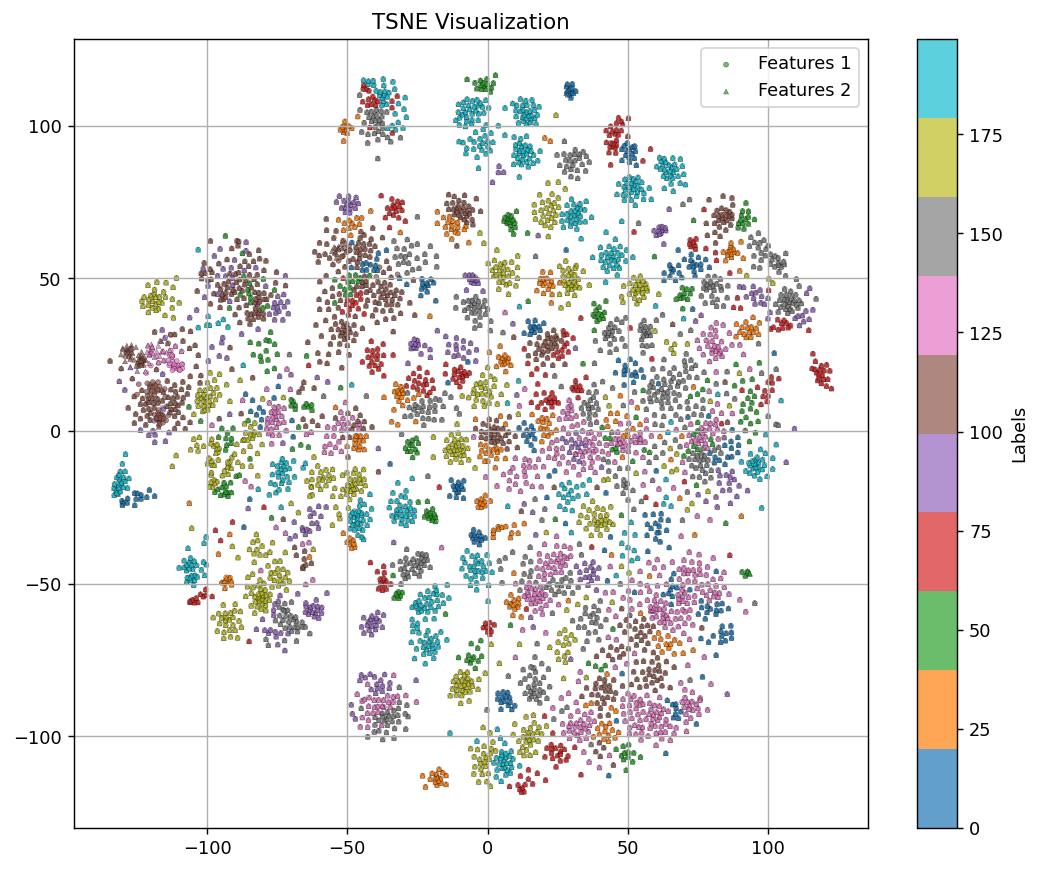

tensor([[-2.5407e-06, -4.1035e-03, -1.8343e-03,  ...,  4.4999e-02,
         -4.4400e-07, -1.4083e-03],
        [-2.3148e-04, -5.2794e-03,  8.9256e-03,  ..., -5.3256e-03,
         -1.1967e-05,  4.2120e-03],
        [-1.4033e-04, -4.2451e-03,  4.8278e-03,  ...,  1.6947e-02,
         -2.5585e-05,  1.7526e-03],
        ...,
        [-8.3370e-07, -4.7271e-03,  1.4179e-02,  ..., -4.3899e-03,
         -1.3068e-05,  1.0933e-02],
        [-1.6788e-06, -6.8567e-03,  3.4669e-02,  ...,  2.8026e-02,
         -1.7879e-05,  2.3536e-02],
        [-3.3859e-06, -5.5891e-03,  2.6049e-02,  ..., -4.5540e-03,
         -6.5667e-05,  3.7050e-02]])

In [15]:
features, filtered_labels = synthesis_novel()

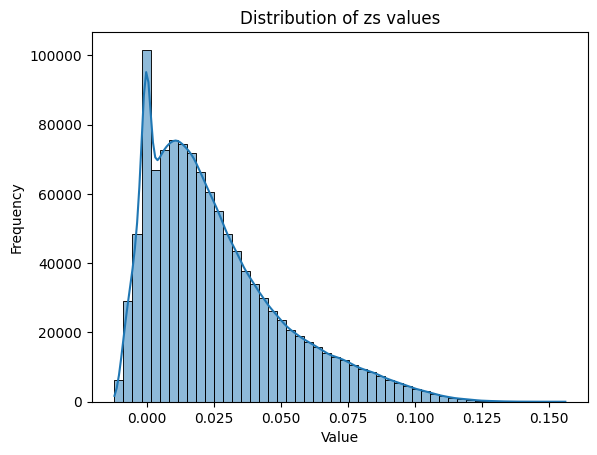

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 zs 是形状为 (n, zs_dim) 的 NumPy 数组
# 示例数据
# zs = np.r
zs_flat = features.flatten()

# 使用 seaborn 的 distplot 绘制分布图
sns.histplot(zs_flat, kde=True, bins=50)  # 使用 histplot 替代 distplot, kde 表示添加核密度估计曲线
plt.title("Distribution of zs values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()